# P7 : Détectez les Bad Buzz grâce au Deep Learning

## Traitement du contenu des tweets (pour modèle BERT sur TF Hub)

Le modèle BERT c’est une architecture de réseau neuronal conçue par des chercheurs de Google qui a totalement transformé ce qui est à la pointe de la technologie pour les tâches NLP, comme la classification des textes, la traduction, la synthèse et la réponse aux questions.

Maintenant que BERT a été ajouté à TF Hub en tant que module chargeable, il est facile(ish) d’ajouter dans les pipelines de texte Tensorflow existants. Dans un pipeline existant, BERT peut remplacer les calques d’intégration de texte comme ELMO et GloVE. Alternativement, le réglage fin BERT peut fournir à la fois un coup de pouce de précision et un temps d’entraînement plus rapide dans de nombreux cas.

Ici, nous allons former un modèle pour prédire si un tweet est positive ou négative en utilisant BERT dans Tensorflow avec tf hub.

## Installer et importer des dépendances

In [1]:
import tensorflow as tf
tf.test.gpu_device_name ()

C:\Users\JK253\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JK253\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JK253\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


'/device:GPU:0'

In [2]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18121547666303497488
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4181524480
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9168984065581712823
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow_hub as hub
from datetime import datetime
import numpy as np

In [5]:
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

En plus des bibliothèques standard que nous avons importées ci-dessus, j'ai besoin d’installer le paquet python de BERT.

## Importation du jeux de données

In [6]:
data = pd.read_csv('P7_03_fichiercsv_tweet_nettoyé.csv')
data.head()

,label,tweet
0,0,upset cant update facebook texting might cry r...
1,0,dived many time ball managed save rest bound
2,0,whole body feel itchy like fire
3,0,behaving mad cant see
4,0,whole crew


## Mise en place d'un modèle BERT pré-entraîné pour un réglage fin 

Je vais importer le modèle de base BERT qui a 110 millions de paramètres. Il existe un modèle BERT encore plus grand appelé BERT-large qui compte 345 millions de paramètres.

In [7]:
num_classes=len(data.label.unique())

In [8]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT-Base, uncased utilise un vocabulaire de 30 522 mots. Les processus de tokenisation impliquent de diviser le texte d'entrée en une liste de jetons disponibles dans le vocabulaire. Afin de traiter les mots non disponibles dans le vocabulaire, BERT utilise une technique appelée BPE WordPiece à base tokens. Dans cette approche, un mot hors vocabulaire est progressivement découpé en sous-mots et le mot est alors représenté par un groupe de sous-mots. Puisque les sous-mots font partie du vocabulaire, nous avons appris des représentations d'un contexte pour ces sous-mots et le contexte du mot est simplement la combinaison du contexte des sous-mots.

In [9]:
sentences=data['tweet']
labels=data['label']
len(sentences),len(labels)

(1590763, 1590763)

Les phrases contiennent l'intégralité des données de texte et les étiquettes contiennent toutes les étiquettes correspondantes.

Encodage des données textuelles à l'aide de BERT Tokenizer et obtention des input_ids et des masques d'attentions pour alimenter le modèle.

Chargez les phrases dans le Tokenizer BERT.

In [10]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =33,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\JK253\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
len(input_ids),len(attention_masks),len(labels)

(1590763, 1590763, 1590763)

In [12]:
print('Préparation du fichier de pickle.....')

pickle_inp_path='../P7/bert_inp.pkl'
pickle_mask_path='../P7/bert_mask.pkl'
pickle_label_path='../P7/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Préparation du fichier de pickle.....
Pickle files saved as  ../P7/bert_inp.pkl ../P7/bert_mask.pkl ../P7/bert_label.pkl


In [13]:
print('Chargement des fichiers de pickle enregistrés....')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Chargement des fichiers de pickle enregistrés....
Input shape (1590763, 33) Attention mask shape (1590763, 33) Input label shape (1590763,)


Divisez l'ensemble de données (input_ids, attention_masks et labels) en ensembles train et Val (80–20), définir test_size = 0,2, c'est-à-dire 20%

In [14]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)
print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (1272610, 33) Val input shape (318153, 33)
Train label shape (1272610,) Val label shape (318153,)
Train attention mask shape (1272610, 33) Val attention mask shape (318153, 33)


train_test_split : diviser des tableaux ou des matrices en sous-ensembles de train et de test aléatoires.

Paramétrage de la perte, de la métrique et de l'optimiseur.

In [15]:
log_dir='tensorboard_data/tb_bert'
model_save_path='../P7/bert_model.h5'

In [16]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',save_best_only=True),
             keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [29]:
history=bert_model.fit([train_inp,train_mask],train_label, 
                       epochs=2,validation_split=0.2,callbacks=callbacks)

Epoch 1/2
31816/31816 [==============================] - 9148s 288ms/step - loss: 0.4195 - accuracy: 0.8078 - val_loss: 0.4052 - val_accuracy: 0.8160
Epoch 2/2
31816/31816 [==============================] - 9143s 287ms/step - loss: 0.3698 - accuracy: 0.8354 - val_loss: 0.4122 - val_accuracy: 0.8171


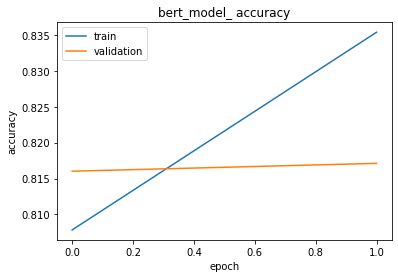

In [30]:
import matplotlib.pyplot as plt

# fonction pour évaluation de l'accuracy
def graphique(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('bert_model_ accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc= 'upper left')
    plt.show()

# appel de la fonction
graphique(history)

## Evaluation sur l'échantillon test du modèle(bert_model)

In [31]:
print(bert_model.evaluate([val_inp,val_mask],val_label))

9943/9943 [==============================] - 935s 94ms/step - loss: 0.4134 - accuracy: 0.8166
[0.4133906662464142, 0.8165599703788757]


## Enregistrement du modèles bert

In [32]:
bert_model.save('../P7/P7_01_modèlesurmesure_avance_bert_model')

INFO:tensorflow:Assets written to: ../P7/P7_01_modèlesurmesure_avance_bert_model\assets


INFO:tensorflow:Assets written to: ../P7/P7_01_modèlesurmesure_avance_bert_model\assets
